<a href="https://colab.research.google.com/github/mrutherfoord/portfolio/blob/master/Boston_Housing_Data_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston Housing Part 2

I will again look at the Boston Housing dataset to look at the predictive capabilities of the Lasso and Elastic Net Linear Regressions as well as ensemble regression models using Random Forests and Gradient Boost.

As in the last assignment, I will be using all of the explanatory variables (with exception to 'neighborhood') and attempting to refine the models to achieve the best predictive accuracy.

In [0]:
import sys
sys.path.append('c:/users/mturn/anaconda3/lib/site-packages')

# ignore some warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

SET_FIT_INTERCEPT = True

# pretty print dataframes
from IPython.display import display

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# cross-validation and metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve, train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from math import sqrt  # for root mean-squared error calculation
from sklearn.preprocessing import StandardScaler

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError, ResidualsPlot
%matplotlib inline

# Data Preparation

I put the housing data in a dataframe and removed the 'neighborhood' column. The desciptive statistics are in part 1 so I opted not to include them in this notebook.

In [0]:
# read data for the Boston Housing Study
# creating data frame
boston_input = pd.read_csv('boston.csv')

# check the pandas DataFrame object boston_input
print('\nBoston DataFrame First 5 Rows:')
display (boston_input.head())

print('\nBoston DataFrame Last 5 Rows:')
display (boston_input.tail())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)


Boston DataFrame First 5 Rows:


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2



Boston DataFrame Last 5 Rows:


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0


Because Linear regressions often do better with scaled data, I chose to standardize the features with scikit-learn's StandardScaler.

In [0]:
# Setting scaler
scaler = StandardScaler()

# Creating dataframes for the explanatory variables and response variable
X = boston.drop(['mv'], axis=1)
y = boston['mv']

# Scaling the explanatory variables
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

print('-' * 50)
print('\nScaled Data')
display(X_scaled.head())
print('-' * 50)
print('\nResponse Variable')
display(y.head())

# Maximum and Minimum of Median Home Prices
print('-' * 50)
print('\nMaximum and Minimum of Median Home Prices')
print(min(y))
print(max(y))

--------------------------------------------------

Scaled Data


,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,-1.026501


--------------------------------------------------

Response Variable


0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: mv, dtype: float64

--------------------------------------------------

Maximum and Minimum of Median Home Prices
5.0
50.0


In [0]:
# Creating an 80/20 training/testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .2, random_state = RANDOM_SEED)

# Checking training set and testing set sizes
print('-' * 50)
print('Explanatory Variables Training Shape: {}'.format(X_train.shape))
print('\nResponse Variable Training Shape: {}'.format(y_train.shape))
print('-' * 50)
print('Explanatory Variables Test Shape: {}'.format(X_test.shape))
print('\nResponse Variable Test Shape: {}'.format(y_test.shape))


--------------------------------------------------
Explanatory Variables Training Shape: (404, 12)

Response Variable Training Shape: (404,)
--------------------------------------------------
Explanatory Variables Test Shape: (102, 12)

Response Variable Test Shape: (102,)


# Lasso Regression

Since I did not use lasso or ElasticNet regressions in Part 1, I decided to try both this time. I used 10 folds for the cross-vaidation.

In [0]:
# Creating 10 folds for cross-validation
kfold = KFold(n_splits=10, random_state=RANDOM_SEED)

# Lasso regression with 1000000 max iterations
lasso_clf = Lasso(max_iter = 10e5, random_state = RANDOM_SEED)

# MSE scoring
scoring = 'neg_mean_squared_error'

# RMSE Cross-validated scores i
RMSE_lasso = np.sqrt(-(cross_val_score(lasso_clf, X_train, y_train, cv=kfold, scoring=scoring)))

# print RMSE
print('-' * 50)
print('RMSE')
print(RMSE_lasso.mean())

--------------------------------------------------
RMSE
5.310989775213106


The RMSE seems very high with a standard lasso regression with no hyperparameter tuning. With a median value of 21.1, the error is about 25%. 

I wanted to take a look at the learning curve as well as do a grid search to see if tuning the model would yield better results.

In [0]:
# Training set sizes
train_sizes = [1, 50, 100, 150, 200, 250, 300, 350, 400, 455]

# Learning curve for lasso regression with 10-fold cross-validation
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = lasso_clf, X = X_scaled,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

# Means for training scores and validation scores
train_scores_mean = np.sqrt(-train_scores.mean(axis = 1))
validation_scores_mean = np.sqrt(-validation_scores.mean(axis = 1))

(0, 10)

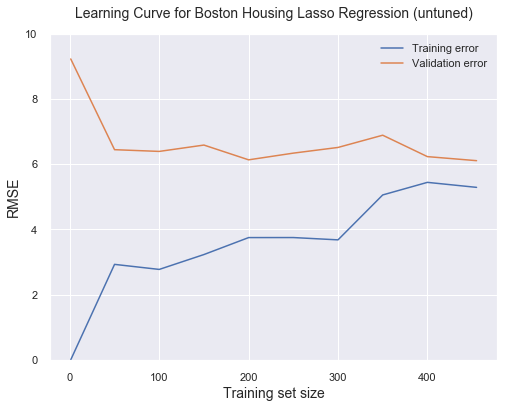

In [0]:
# Seaborn style
sns.set(style='darkgrid')

# Plot of training and validation scores
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Plot labeling
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curve for Boston Housing Lasso Regression (untuned)', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0,10)

The variance between the training and validation errors doesn't look to bad, but it looks like the training set has a lot of bias.

--------------------------------------------------
Best cross-validation score RSME: 4.88
--------------------------------------------------
Best parameters: {'alpha': 0.033932217718953266}


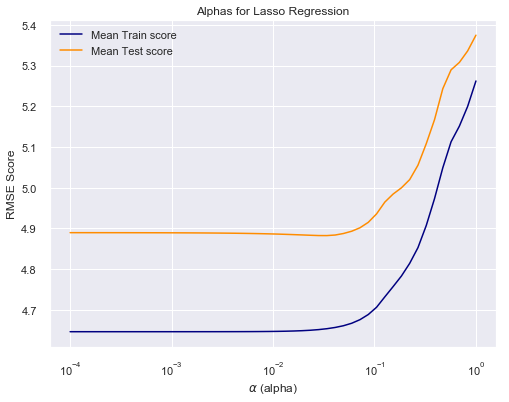

In [0]:
# Setting alpha parameters to search through
alphas = np.logspace(-4, 0)
param_grid = {'alpha': alphas}

# Grid search with 10-fold cross-validation
grid = GridSearchCV(lasso_clf, param_grid, cv=10, iid=False, return_train_score=True, scoring = scoring)
grid.fit(X_train, y_train)

print('-' * 50)
print('Best cross-validation score RSME: {:.2f}'.format(np.sqrt(-grid.best_score_)))
print('-' * 50)
print('Best parameters:', grid.best_params_)

# Mean training and test scores usind MSE scoring
train_scores_mean = grid.cv_results_["mean_train_score"]
test_scores_mean = grid.cv_results_["mean_test_score"]

# Converting to RMSE
train_scores_mean = np.sqrt(-train_scores_mean)
test_scores_mean = np.sqrt(-test_scores_mean)

# Plot labeling
plt.figure(figsize=(8,6))
plt.title('Alphas for Lasso Regression')
plt.xlabel('$\\alpha$ (alpha)')
plt.ylabel('RMSE Score')

# plot train scores
plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
             color='navy')
plt.semilogx(alphas, test_scores_mean,
             label='Mean Test score', color='darkorange')
plt.legend(loc='best')
plt.show()

The new RMSE is much better, but still not great. I went ahead and trained a new lasso regression using the best alpha found to look

In [0]:
# New Lasso with tuned alpha 
lasso_clf1 = Lasso(alpha = .0339, max_iter = 10e5, random_state = RANDOM_SEED)
lasso_clf1.fit(X_train, y_train)

# Calculating RMSE
RMSE_lasso1 = np.sqrt(-(cross_val_score(lasso_clf1, X_train, y_train, cv=kfold, scoring=scoring)))

print('Lasso Regression Results')
print('-' * 50)
print('R^2 Score for Training Set: {:.2f}'.format(lasso_clf1.score(X_train, y_train)))
print('\nRMSE for Training Set: {:.2f}'.format(RMSE_lasso1.mean()))

# Predictions
predict = lasso_clf1.predict(X_test)

print('-' * 50)
print('R^2 Score for Test Set: {:.2f}'.format(r2_score(y_test, predict)))
print('\nMSE for Test Set', (np.sqrt(mean_squared_error(y_test, predict),)))


Lasso Regression Results
--------------------------------------------------
R^2 Score for Training Set: 0.73

RMSE for Training Set: 4.79
--------------------------------------------------
R^2 Score for Test Set: 0.75

MSE for Test Set 4.963479957707169


The alpha adjustment does improve the model a little bit, but I would need to look to feature engineering to improve model performance from here since I do not have more instances in this data set to add.

I also created a learning curve to see how the change affects the model.

In [0]:
# Learning curve for lasso regression with 10-fold cross-validation
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = lasso_clf1, X = X_scaled,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')
# Means for training scores and validation scores
train_scores_mean = np.sqrt(-train_scores.mean(axis = 1))
validation_scores_mean = np.sqrt(-validation_scores.mean(axis = 1))

(0, 10)

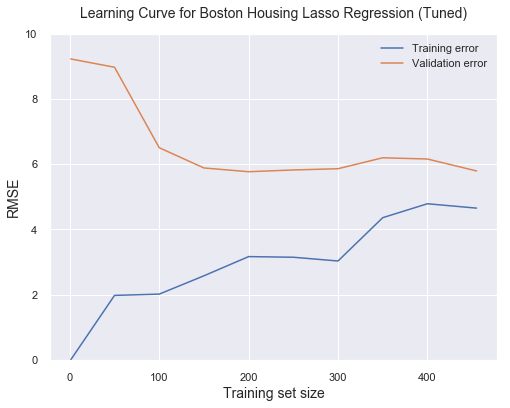

In [0]:
# Plot of training and validation scores
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Plot labeling
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curve for Boston Housing Lasso Regression (Tuned)', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0,10)

I next used the Yellowbrick visualizer package to create a prediction error and residuals plot.

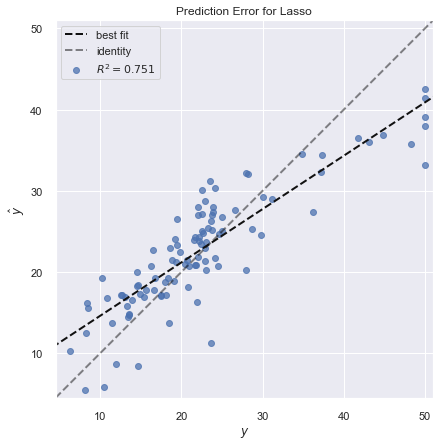

In [0]:
predict_error_lasso = PredictionError(lasso_clf1, size = (500, 500))

predict_error_lasso.fit(X_train, y_train)
predict_error_lasso.score(X_test, y_test)
predict_error_lasso.poof()             

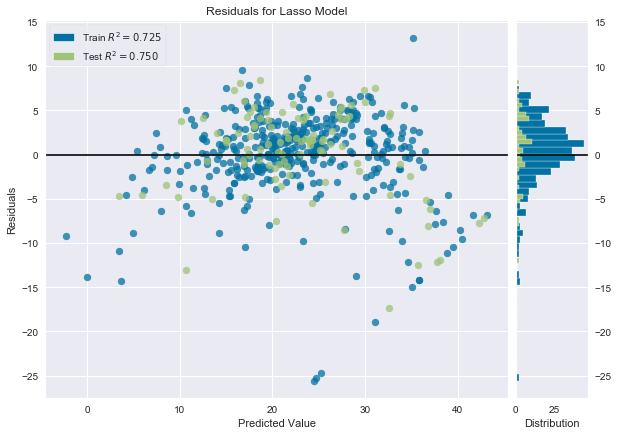

In [0]:
residuals_lasso = ResidualsPlot(lasso_clf1, size = (700, 500))

residuals_lasso.fit(X_train, y_train)
residuals_lasso.score(X_test, y_test)  
residuals_lasso.poof()                 

I really like the way the yellowbrick residual plot overlays the test set over the training set as well as adds a distribution. I can definitely see that the distribution skews right and that there is a diagonal line which indicates a collinearity problem. Potentially removing outliers and collinear features could help improve this model further.

# Elastic Net Regression

Next, I decided to try Elastic Net to see how it compares to the Lasso regression. Again I used 10-fold cross-validation.

In [0]:
# Creating 10-fold cross-validation
kfold = KFold(n_splits=10, random_state=RANDOM_SEED)

# Elastic Net model
elastic_clf = ElasticNet(max_iter = 1000000, random_state = RANDOM_SEED)

# Setting up scoring as MSE 
scoring = 'neg_mean_squared_error'

# Caluclating RMSE
RMSE_elastic = np.sqrt(-(cross_val_score(elastic_clf, X_train, y_train, cv=kfold, scoring=scoring)))

print('-' * 50)
print('RMSE')
print(RMSE_elastic.mean())

--------------------------------------------------
RMSE
5.460901329625305


This model does worse untuned than the Lasso Regression. I created a learning curve to see what is happening.

In [0]:
# Learning curve for ElasticNet regression with 10-fold cross-validation
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = elastic_clf, X = X_scaled,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

# Means for training scores and validation scores
train_scores_mean = np.sqrt(-train_scores.mean(axis = 1))
validation_scores_mean = np.sqrt(-validation_scores.mean(axis = 1))

(0, 10)

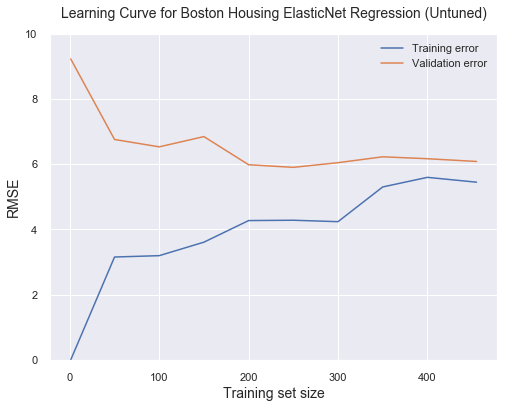

In [0]:
# Plot of training and validation scores
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Plot labeling
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curve for Boston Housing ElasticNet Regression (Untuned)', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0,10)

Here I can see the trade-off between bias and variance taking place. This model has less variance than Lasso, but more bias. 

The next step is to use GridSearch to find the best alpha and l1 ratio.

In [0]:
# Setting parameters for alpha, and the l1 ratio.
param_grid = {'alpha': np.logspace(-4, 0), 'l1_ratio' : np.array([.1, .5, .7, .9, .95, .99, 1])}

# Creating grid search
grid_en = GridSearchCV(elastic_clf, param_grid, cv = 10, iid = False, return_train_score = True, scoring = scoring)
grid_en.fit(X_train, y_train)

# Printing results
print('-' * 50)
print("Best cross-validation score RSME: {:.2f}".format(np.sqrt(-grid_en.best_score_)))
print('-' * 50)
print("Best parameters: ", grid_en.best_params_)

--------------------------------------------------
Best cross-validation score RSME: 4.88
--------------------------------------------------
Best parameters:  {'alpha': 0.033932217718953266, 'l1_ratio': 1.0}


The new scores are very similar to the Lasso regression after tuning. I created a new model based on the best parameters found.

In [0]:
# New Elastic Net model
elastic_clf1 = ElasticNet(alpha = .03393, max_iter = 1000000, l1_ratio = 1.0, random_state = RANDOM_SEED)
elastic_clf1.fit(X_train, y_train)

# Calculating RMSE
RMSE_elastic1 = np.sqrt(-(cross_val_score(elastic_clf1, X_train, y_train, cv=kfold, scoring=scoring)))

# Predictions
predict = elastic_clf1.predict(X_test)

# Results
print('Elastic Net Results')
print('-' * 50)
print('R^2 for Training Set: {:.2f}'.format(elastic_clf1.score(X_train, y_train)))
print('RMSE for Training Set: {:.2f}'.format(RMSE_elastic1.mean()))
print('-' * 50)
print('R^2 for Test Set: {:.2f}'.format(r2_score(y_test, predict)))
print('RMSE for Test Set', np.sqrt(mean_squared_error(y_test, predict)))


Elastic Net Results
--------------------------------------------------
R^2 for Training Set: 0.73
RMSE for Training Set: 4.79
--------------------------------------------------
R^2 for Test Set: 0.75
RMSE for Test Set 4.963498893473021


The results are the same as the tuned Lasso regression. I created another learning curve to compare.

In [0]:
# Learning curve for ElasticNet regression with 10-fold cross-validation
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = elastic_clf1, X = X_scaled,
                                                   y = y, train_sizes = train_sizes, cv = 10,
                                                   scoring = 'neg_mean_squared_error')

# Means for training scores and validation scores
train_scores_mean = np.sqrt(-train_scores.mean(axis = 1))
validation_scores_mean = np.sqrt(-validation_scores.mean(axis = 1))

(0, 10)

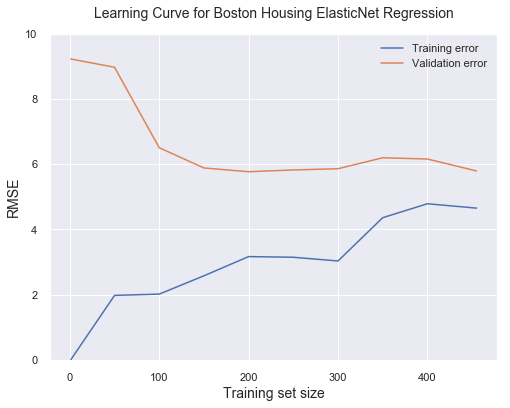

In [0]:
# Plot of training and validation scores
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

# Plot labeling
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning Curve for Boston Housing ElasticNet Regression (Tuned)', fontsize = 14, y = 1.03)
plt.legend()
plt.ylim(0,10)

The learning curve also resembles the tuned Lasso Regression. The bias is lower, but there is now more variance.

I also created prediction error plots as well as a residual plot to compare.

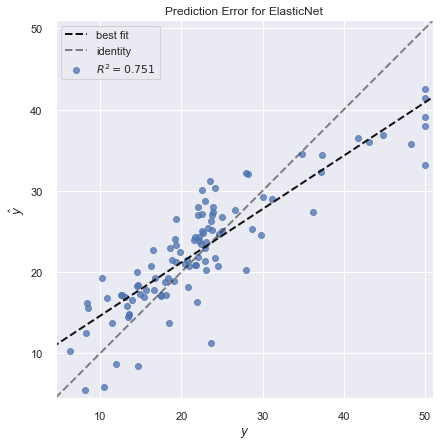

In [0]:
# Prediction error plot

predict_error_elastic = PredictionError(elastic_clf1, size = (500, 500))

predict_error_elastic.fit(X_train, y_train)
predict_error_elastic.score(X_test, y_test) 
predict_error_elastic.poof()    

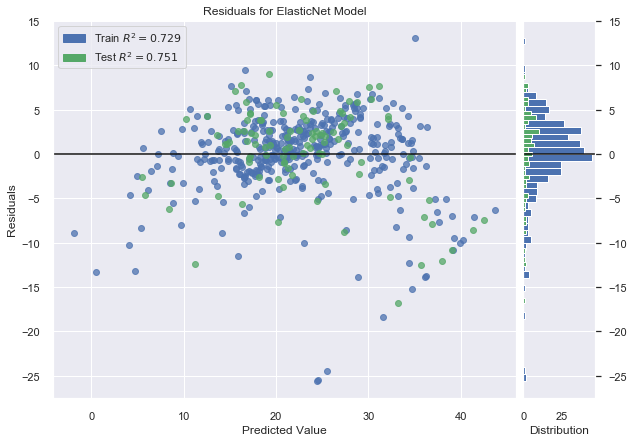

In [0]:
# Residual Plot
residuals_elastic = ResidualsPlot(elastic_clf1, size = (700, 500))

residuals_elastic.fit(X_train, y_train)
residuals_elastic.score(X_test, y_test)  
residuals_elastic.poof()  

With both linear regression models tuned, they seem pretty interchangable. As for their predictive power, other methods will need to be employed to make these models fit better.

# Random Forest Regression

Ensemble models starting with Random Forest is what I looked at next. Because Random Forests are partition-based, scaling is not necessary. I created a new training and testing set that contains the unscaled data.

In [0]:
# New unscaled training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = RANDOM_SEED)

# Random forest model
rforest = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = RANDOM_SEED, oob_score = True)
rforest.fit(X_train,y_train)

# Calculating RMSE with 10-fold cross-validation
rf_RMSE = np.sqrt(-(cross_val_score(rforest, X_train, y_train, cv=kfold, scoring=scoring)))

#Predictions
rf_predict = rforest.predict(X_test)
rf_RMSE_predict = np.sqrt(mean_squared_error(y_test, rf_predict))

# Results
print('Random Forest Results')
print('-' * 50)
print('RMSE for Training Set: {:2f}'.format(rf_RMSE.mean()))
print('Out-of-Bag Score for Training Set: {:2f}'.format(rforest.oob_score_))
print('-' * 50)
print('RMSE for Test Set: {:2f}'.format(rf_RMSE_predict))

Random Forest Results
--------------------------------------------------
RMSE for Training Set: 3.028227
Oob_Score for Training Set: 0.888970
--------------------------------------------------
RMSE for Test Set: 2.938434


This result is much better than than any of the linear regression models I have tried. I wanted to see if it could be improved by using GridSearchCV. I decided to try between 50 and 200 trees with a max depth between 2 and 30. I also set the number of folds to 5 for a total of 1120 fits. If the dataset was larger, I would probably use RandomizedSearchCV, but I figured my computer could handle a grid search on the smaller set.

In [0]:
# Parameters to test
tuned_parameters = [{
    'n_estimators': np.arange(50, 210, 10),
    'random_state': [RANDOM_SEED],
    'max_depth': np.arange(2, 30, 2),
}]

# Grid Search
grid = GridSearchCV(RandomForestRegressor(),tuned_parameters, 
                       cv=5, scoring=scoring, refit='neg_mean_squared_error', iid=False,
                       verbose=2, return_train_score = True, n_jobs=-1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 681 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1046 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid=[{'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160, 170,
       180, 190, 200]), 'random_state': [1], 'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28])}],
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring='neg_mean_squared_error',
       verbose=2)

In [0]:
print('GridSearchCV Results')
print('-' * 50)
print("Best cross-validation score RSME: {:.2f}".format(np.sqrt(-grid.best_score_)))
print("Best parameters: ", grid.best_params_)

GridSearchCV Results
--------------------------------------------------
Best cross-validation score RSME: 3.08
Best parameters:  {'max_depth': 18, 'n_estimators': 60, 'random_state': 1}


The cross-validation score is slightly worse than the untuned model, but I wanted to try the parameters that worked best.

In [0]:
# New random forest
rforest1 = RandomForestRegressor(n_estimators = 60, max_depth = 18, n_jobs = -1, random_state = RANDOM_SEED, oob_score = True)
rforest1.fit(X_train,y_train)

# RMSE Cross-validation with 10 folds
rf1_RMSE = np.sqrt(-(cross_val_score(rforest1, X_train, y_train, cv=kfold, scoring=scoring)))

# Predictions
rf_predict1 = rforest1.predict(X_test)

# RMSE for predictions
rf_RMSE_predict1 = np.sqrt(mean_squared_error(y_test, rf_predict1))

# Results
print('New Random Forest Results')
print('-' * 50)
print('RMSE for Training Set: {:.2f}'.format(rf1_RMSE.mean()))
print('Out-of-Bag Score for Training Set {:.2f}'.format(rforest1.oob_score_))
print('-' * 50)
print('RMSE for Training Set {:.2f}'.format(rf_RMSE_predict1))

New Random Forest Results
--------------------------------------------------
RMSE for Training Set: 3.07
Out-of-Bag Score for Training Set 0.89
--------------------------------------------------
RMSE for Training Set 2.93


The scores are pretty much the same as the model without tuned parameters. 

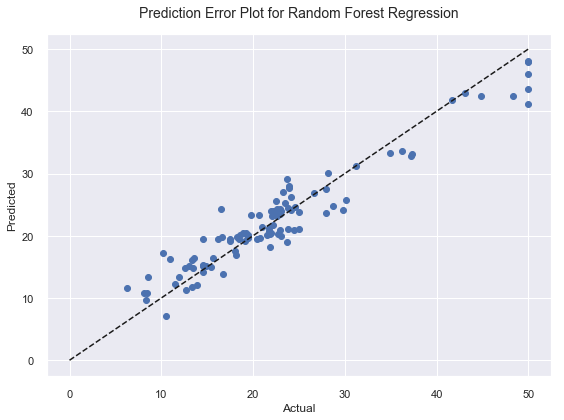

In [0]:
plt.figure(figsize=(8, 6))
plt.title('Prediction Error Plot for Random Forest Regression', fontsize = 14, y = 1.03)
plt.scatter(y_test, rf_predict)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()

The prediction error plot looks much better than the linear regression plots. Next I took a look at feature importances for the original random forest model I made.

In [0]:
# Get numerical feature importances
importances = list(rforest.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: lstat                Importance: 0.51
Variable: rooms                Importance: 0.28
Variable: dis                  Importance: 0.07
Variable: crim                 Importance: 0.04
Variable: nox                  Importance: 0.03
Variable: age                  Importance: 0.02
Variable: tax                  Importance: 0.02
Variable: ptratio              Importance: 0.02
Variable: indus                Importance: 0.01
Variable: zn                   Importance: 0.0
Variable: chas                 Importance: 0.0
Variable: rad                  Importance: 0.0


A house's lower status seems to be the most important feature for the model, with the number of rooms the second most important. I also visualized the importances in the ploy below.

Text(0.5, 1.0, 'Feature Importances for Random Forest')

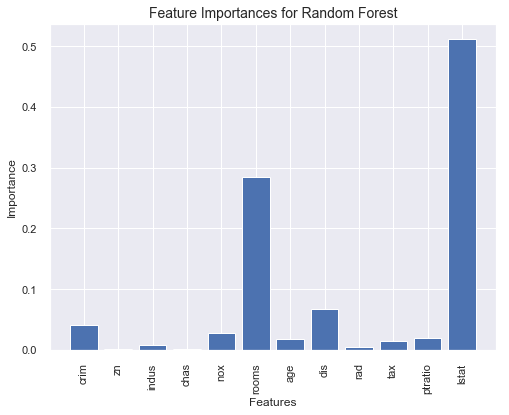

In [0]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# bar chart
plt.figure(figsize=(8, 6))
plt.bar(x_values, importances, orientation = 'vertical')

# Labeling
plt.xticks(x_values, X.columns, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Feature Importances for Random Forest', fontsize=14)

# Gradient Boosting

The next ensemble model I tried was Gradient Boosting. Again I used unscaled data for the model.

In [0]:
# Gradient Boost Model
gb = GradientBoostingRegressor(n_estimators = 1000, random_state = RANDOM_SEED, max_depth = 2)
gb.fit(X_train, y_train)

# RMSE scoring with 10-fold cross-validation
gb_RMSE = np.sqrt(-(cross_val_score(gb, X_train, y_train, cv=kfold, scoring=scoring)))

# Predictions
gb_predict = gb.predict(X_test)
gb_predict_RMSE = np.sqrt(mean_squared_error(y_test, gb_predict))

# Results
print('Gradient Boosting Results')
print('-' * 50)
print('RMSE for Training Set: {:.2f}'.format(gb_RMSE.mean()))
print('RMSE for Testing Set: {:.2f}'.format(gb_predict_RMSE))

Gradient Boosting Results
--------------------------------------------------
RMSE for Training Set: 3.28
RMSE for Testing Set: 3.03


The Gradient Boost model does not perform as well as the Random Forest, but maybe a little tuning can improve it. I used the code found in the Geron book to search for the best number of estimators.

In [0]:
# New Gradient Boost model
gb_best = GradientBoostingRegressor(max_depth = 2, warm_start = True, random_state = RANDOM_SEED, learning_rate = .1)

# Geron code to find best number of estimator
min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,3000):
    gb_best.n_estimators = n_estimators
    gb_best.fit(X_train, y_train)
    gb_best_predict = gb_best.predict(X_test)
    val_error = mean_squared_error(y_test, gb_best_predict)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

# Best RMSE
gb_best_predict_RMSE = np.sqrt(mean_squared_error(y_test, gb_predict))

# Results
print('-' * 50)
print('Best number of estimators: {}'.format(gb_best.n_estimators))            
print('Best predicted RMSE: {:.2f}'.format(gb_best_predict_RMSE))

--------------------------------------------------
Best number of estimators: 59
Best predicted RMSE: 3.03


The tuned version yields the same results as the untuned model. I next plotted the prediction error.

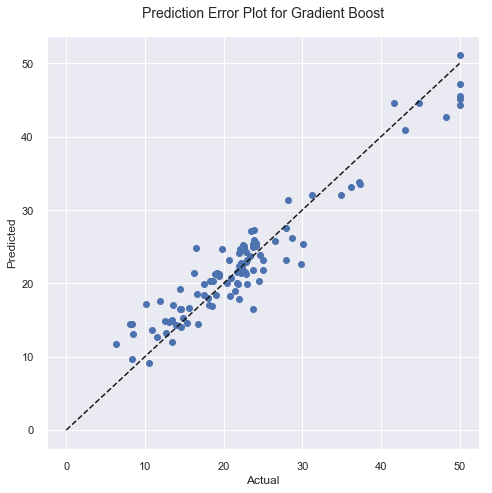

In [0]:
# Prediction error plot
plt.figure(figsize=(7, 7))
plt.title('Prediction Error Plot for Gradient Boost', fontsize = 14, y = 1.03)
plt.scatter(y_test, gb_best_predict)
plt.plot([0, 50], [0, 50], '--k')
plt.axis('tight')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()

This plot looks good, but not quite as good as the Random Forest. I next looked at feature importance for the model.

In [0]:
# Get numerical feature importances
importances = list(gb_best.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Results
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: lstat                Importance: 0.49
Variable: rooms                Importance: 0.32
Variable: dis                  Importance: 0.07
Variable: nox                  Importance: 0.04
Variable: ptratio              Importance: 0.04
Variable: crim                 Importance: 0.03
Variable: indus                Importance: 0.01
Variable: tax                  Importance: 0.01
Variable: zn                   Importance: 0.0
Variable: chas                 Importance: 0.0
Variable: age                  Importance: 0.0
Variable: rad                  Importance: 0.0


This model puts slightly less emphasis on the lstat feature and a little more than the number of rooms. I plotted it as well.

Text(0.5, 1.0, 'Feature Importance for Gradient Boost')

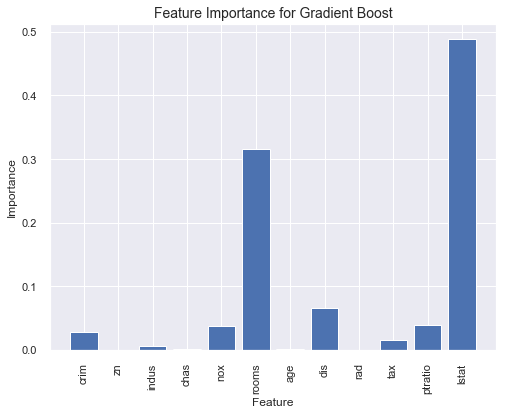

In [0]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(x_values, importances, orientation = 'vertical')

# Labels
plt.xticks(x_values, X.columns, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature') 
plt.title('Feature Importance for Gradient Boost', fontsize=14)

# Conclusion

Although I had more success with Linear Regression and tuning on this assignment than the last, It's clear that the ensemble learning models are more suited for this task. The Random Forest model reduced the RMSE by $2000, which is about a ten percent improvement from the tuned linear regression models.

I would recommend that the company use the Random Forest model, and look to focus on at least low-status, rooms, distance, and crime. I would also look to using a log-transform or removing outliers for the response variable to normalize its distribution before fitting the model.